In [8]:
import os,glob
import numpy as np
import xroms
from xroms import utilities as xrutil
import xarray as xr
import pandas as pd
import xesmf as xe
import cartopy 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import datetime
import romsutil as rutil
from  scipy.interpolate import interp1d
import netCDF4 as nc

import warnings
warnings.filterwarnings("ignore")

import time
%matplotlib widget

In [9]:
from dask.distributed import Client
import dask.array as da
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34859/status,
Dashboard: http://127.0.0.1:34859/status,Workers: 6
Total threads: 36,Total memory: 376.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38020,Workers: 6
Dashboard: http://127.0.0.1:34859/status,Total threads: 36
Started: Just now,Total memory: 376.39 GiB
Comm: tcp://127.0.0.1:35348,Total threads: 6
Dashboard: http://127.0.0.1:35096/status,Memory: 62.73 GiB
Nanny: tcp://127.0.0.1:46473,


In [10]:
%%time
#Initial setup/parameters
today=datetime.datetime.now().strftime('%Y%m%d')
today='20221102'#This we will get rid of. 
tunits=datetime.datetime.now().strftime('days since %Y-%m-%d')
rtime=np.datetime64(datetime.datetime.now().date())

#Donor grid Info
# % Enter vertical characteristics for the L0 grid
L0grdfile='/home/hunter/roms/NOPP/forecast/grids/L0/NewEngland_qck_grid.nc' # can be a thredds url
#Vertical coordinate information
L0Vtransform= 2
L0Vstretching= 4
L0theta_s = 8.0
L0theta_b = 4.0
L0hc=200
L0N=50
#Donor inputfiles
datadir=f'/home/hunter/roms/NOPP/forecast/{today}/roms_L0/'# can be a thredds url
L0his=datadir+'roms_his_forNewEngland.nc' 
L0qck=datadir+'roms_qck_forNewEngland.nc' 


#Receiver Grid Info
L1grdfile='/home/hunter/roms/NOPP/forecast/grids/L1/NYBIGHT_grd_L1.nc' # can be a thredds url
L1theta_s=8.0
L1theta_b=4.0
L1Tcline=20.0
L1N=30
L1Vtransform  =2        #vertical transformation equation
L1Vstretching =4        #vertical stretching function
L1hc=200
Nbed=1
Nveg=1
NCS=0
NNS=1


(s_w_L0,C_w_L0)=rutil.stretching(L0Vstretching,L0theta_s,L0theta_b,L0hc,L0N,1)
(s_r_L0,C_r_L0)=rutil.stretching(L0Vstretching,L0theta_s,L0theta_b,L0hc,L0N,0)
(s_w_L1,C_w_L1)=rutil.stretching(L1Vstretching,L1theta_s,L1theta_b,L1hc,L1N,1)
(s_r_L1,C_r_L1)=rutil.stretching(L1Vstretching,L1theta_s,L1theta_b,L1hc,L1N,0)

#Receiver Output files
inifile=f'/home/hunter/roms/NOPP/output/receiver_{today}_ini.nc'
bryfile=f'/home/hunter/roms/NOPP/output/receiver_{today}_bry.nc'
clmfile=f'/home/hunter/roms/NOPP/output/receiver_{today}_clm.nc'

#Receiver Output time dimensoons
#High resolution time dimension, maybe barotropic  
t2step=1
t2N=121
t2end=t2step*t2N
#Low resolution time dimension, maybe Baroclinic
t3step=8
t3N=6
t3end=t3step*t3N

#Output file flags, if True create file
INIflag=False
CLMflag=False
BRYflag=True



CPU times: user 572 µs, sys: 0 ns, total: 572 µs
Wall time: 338 µs


In [11]:
%%time
#Lazy read Grid files 
dsgrd=xroms.open_netcdf(L0grdfile)
dsgrd=dsgrd.drop_vars({'lon_rho', 'lat_rho', 'lon_u', 'lat_v', 'lat_u', 'lon_v'})

cfgrd=xroms.open_netcdf(L1grdfile)
cfgrd.attrs['sc_r']=L1N
cfgrd.attrs['sc_w']=L1N+1
cfgrd.attrs['time']=1
cfgrd.attrs['Nbed']=1
cfgrd.attrs['Nveg']=1
cfgrd.attrs['NCS']=0
cfgrd.attrs['NNS']=1
cfgrd.attrs['t2d']=t2N
cfgrd.attrs['t3d']=t3N





#Lazy read Input model files 
dsqckl0=xr.open_dataset(L0qck)
dshisl0=xr.open_dataset(L0his)
dsqckl0=xr.merge([dsqckl0,dsgrd])

#extract only history file times from quick files
dsl0sub=dsqckl0.sel(ocean_time=dshisl0.ocean_time.values)

#Add Depth averged data data to hsitory data. ALso include depth parameters. 
dshisl0=xr.merge([dshisl0,dsgrd])
dshisl0['ubar']=dsl0sub['ubar']
dshisl0['vbar']=dsl0sub['vbar']
dshisl0['zeta']=dsl0sub['zeta']
dshisl0['s_w']=('s_w',s_w_L0)
dshisl0['Cs_w']=('s_w',C_w_L0)
dshisl0['s_r']=('s_rho',s_r_L0)
dshisl0['Cs_r']=('s_rho',C_r_L0)
dshisl0.attrs['hc']=L0hc


#Create input grid
tmp=dsl0sub.rename({'mask_rho':'mask'})
tmp=tmp.rename({'lat_rho':'lat'})
tmp=tmp.rename({'lon_rho':'lon'})
# Frozen({'one': 1, 'bath': 1, 'eta_rho': 3, 'xi_rho': 662, 'eta_v': 2, 'xi_u': 661})
# Frozen({'one': 1, 'bath': 1, 'eta_rho': 2, 'xi_rho': 662, 'eta_v': 1, 'xi_u': 661})
# Frozen({'one': 1, 'bath': 1, 'eta_rho': 327, 'xi_rho': 3, 'eta_v': 326, 'xi_u': 2})
# Frozen({'one': 1, 'bath': 1, 'eta_rho': 327, 'xi_rho': 2, 'eta_v': 326, 'xi_u': 1})

#Create output grids. 
varnew_south=xroms.subset(cfgrd,Y=slice(0,3))
varnew_south=varnew_south.rename({'lat_rho':'lat'})
varnew_south=varnew_south.rename({'lon_rho':'lon'})
varnew_south=varnew_south.rename({'mask_rho':'mask'})

varnew_north=xroms.subset(cfgrd,Y=slice(cfgrd.sizes['eta_rho']-3,cfgrd.sizes['eta_rho']))
varnew_north=varnew_north.rename({'lat_rho':'lat'})
varnew_north=varnew_north.rename({'lon_rho':'lon'})
varnew_north=varnew_north.rename({'mask_rho':'mask'})


varnew_west=xroms.subset(cfgrd,X=slice(0,3))
varnew_west=varnew_west.rename({'lat_rho':'lat'})
varnew_west=varnew_west.rename({'lon_rho':'lon'})
varnew_west=varnew_west.rename({'mask_rho':'mask'})


varnew_east=xroms.subset(cfgrd,X=slice(cfgrd.sizes['xi_rho']-3,cfgrd.sizes['xi_rho']))
varnew_east=varnew_east.rename({'lat_rho':'lat'})
varnew_east=varnew_east.rename({'lon_rho':'lon'})
varnew_east=varnew_east.rename({'mask_rho':'mask'})


print(varnew_south.sizes)
# print(varnew_north.sizes)
# print(varnew_east.sizes)
# print(varnew_west.sizes)

#create the regridders. L0-L1 spatial grids. 
regridder_W = xe.Regridder( tmp,varnew_west, "bilinear",extrap_method="nearest_s2d",locstream_out=False)
regridder_E = xe.Regridder( tmp,varnew_east, "bilinear",extrap_method="nearest_s2d",locstream_out=False)
regridder_S = xe.Regridder( tmp,varnew_south, "bilinear",extrap_method="nearest_s2d",locstream_out=False)
regridder_N = xe.Regridder( tmp,varnew_north, "bilinear",extrap_method="nearest_s2d",locstream_out=False)


Frozen({'one': 1, 'bath': 1, 'eta_rho': 3, 'xi_rho': 662, 'eta_v': 2, 'xi_u': 661})
CPU times: user 4.49 s, sys: 232 ms, total: 4.72 s
Wall time: 7.7 s


In [12]:
# from importlib import reload
# reload(rutil)
# reload(xroms)

In [32]:
%%time
#Boundary FILE CODE
if BRYflag:
    print(f'Procesing Boundary Condition file: {bryfile}')
    rutil.create_bdry_file(bryfile,cfgrd,tunits)
##############################################################################################
#inner function to take care of some array bookkeeping, mostly to get grid cell depths. 
##############################################################################################
    def dataset_get_Z(xromsds,varnew):
        #Fixxing gridde
        xromsds['s_w']=('s_w',s_w_L0)
        xromsds['Cs_w']=('s_w',C_w_L0)
        xromsds['s_rho']=('s_rho',s_r_L0)
        xromsds['Cs_r']=('s_rho',C_r_L0)
        xromsds.attrs['hc']=L0hc
        xromsds=xromsds.unify_chunks()   
        xromsds = xromsds.chunk({'xi_rho': xromsds.sizes['xi_rho']})
        xromsds = xromsds.chunk({'eta_rho': xromsds.sizes['eta_rho']})
        xromsds = xromsds.chunk({'eta_v': xromsds.sizes['eta_v']})
        xromsds = xromsds.chunk({'xi_u': xromsds.sizes['xi_u']})

        (xromsds,gridhisL1)=xroms.roms_dataset( xromsds,Vtransform=L0Vtransform)
        
        xromsds_z=xromsds.zeta.to_dataset()
        xromsds_z=xr.merge([xromsds_z,varnew],join='override', compat='override')
        xromsds_z['s_w']=('s_w',s_w_L1)
        xromsds_z['Cs_w']=('s_w',C_w_L1)
        xromsds_z['s_rho']=('s_rho',s_r_L1)
        xromsds_z['Cs_r']=('s_rho',C_r_L1)
        xromsds_z.attrs['hc']=L1hc

        (xromsds_z,gridhisL1_z)=xroms.roms_dataset(xromsds_z,Vtransform=L1Vtransform)

        return xromsds,xromsds_z
        

##############################################################################################
# 3-D variable interpolation
##############################################################################################
    #for ind,t in enumerate(dshisl0.ocean_time.values[0:t3end]):    
    for ind,t in enumerate(dshisl0.ocean_time.values[0:1]):
        print(f'Procesing Boundary Condition time: {t}')
        dshisl0_I=dshisl0.sel(ocean_time=t)
        dshisl0_I.load()
        #convert UV to rho grid and rotate by angle.  
        (xromhisL0,gridhisL0)=xroms.roms_dataset(dshisl0_I,Vtransform=L0Vtransform)
        uv=rutil.uv_rot(xromhisL0.u, xromhisL0.v, gridhisL0,xromhisL0.angle)
        ruhis=uv[0]
        rvhis=uv[1]
        xromhisL0=xr.merge([xromhisL0,ruhis,rvhis])
        uv=rutil.uv_rot_2d(xromhisL0.ubar, xromhisL0.vbar, gridhisL0,xromhisL0.angle)
        ru=uv[0]
        rv=uv[1]
        xromhisL0=xr.merge([xromhisL0,ru,rv])
        # this just makes sure chunking is good.  
        dimension_to_remove = 'xi_u'
        xromhisL0 = xromhisL0.drop_vars([var for var in xromhisL0.variables if dimension_to_remove in xromhisL0[var].dims])
        dimension_to_remove ='eta_v'
        xromhisL0 = xromhisL0.drop_vars([var for var in xromhisL0.variables if dimension_to_remove in xromhisL0[var].dims])
        
        
##############################################################################################
#Regridding
##############################################################################################
        xromhisL1_N = regridder_N(xromhisL0,keep_attrs=True)
        xromhisL1_N['xi_u']=varnew_north['xi_u']
        xromhisL1_N['eta_v']=varnew_north['eta_v']
        
        xromhisL1_S = regridder_S(xromhisL0,keep_attrs=True)
        xromhisL1_S['xi_u']=varnew_south['xi_u']
        xromhisL1_S['eta_v']=varnew_south['eta_v']

        xromhisL1_E = regridder_E(xromhisL0,keep_attrs=True)
        xromhisL1_E['xi_u']=varnew_east['xi_u']
        xromhisL1_E['eta_v']=varnew_east['eta_v']

        xromhisL1_W = regridder_W(xromhisL0,keep_attrs=True)
        xromhisL1_W['xi_u']=varnew_west['xi_u']
        xromhisL1_W['eta_v']=varnew_west['eta_v']
        
##############################################################################################
#Get depths of L0 and L1 grid. 
##############################################################################################
     
        tmp=dataset_get_Z(xromhisL1_S,varnew_south)
        xromhisL1_S=tmp[0]
        xromhisL1_S_z=tmp[1]
        tmp=dataset_get_Z(xromhisL1_N,varnew_north)
        xromhisL1_N=tmp[0]
        xromhisL1_N_z=tmp[1]
        tmp=dataset_get_Z(xromhisL1_E,varnew_east)
        xromhisL1_E=tmp[0]
        xromhisL1_E_z=tmp[1]
        tmp=dataset_get_Z(xromhisL1_W,varnew_west)
        xromhisL1_W=tmp[0]
        xromhisL1_W_z=tmp[1]


        dim_dict=cfgrd.dims
##############################################################################################
#Initialize Arrays
##############################################################################################
        temp={
            'south':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'north':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'east':np.full((L1N,dim_dict['eta_rho']),np.nan),
            'west':np.full((L1N,dim_dict['eta_rho']),np.nan)
        }
        salt={
            'south':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'north':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'east':np.full((L1N,dim_dict['eta_rho']),np.nan),
            'west':np.full((L1N,dim_dict['eta_rho']),np.nan)
        }
        u_east={
            'south':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'north':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'east':np.full((L1N,dim_dict['eta_rho']),np.nan),
            'west':np.full((L1N,dim_dict['eta_rho']),np.nan)
        }
        v_north={
            'south':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'north':np.full((L1N,dim_dict['xi_rho']),np.nan),
            'east':np.full((L1N,dim_dict['eta_rho']),np.nan),
            'west':np.full((L1N,dim_dict['eta_rho']),np.nan)
        }

# tlat=[]
# tlon=[]
##############################################################################################
#Loading Data for interpolation
##############################################################################################
        maskN=xromhisL1_N_z.mask.isel(eta_rho=-1).values
        tmpNz=xromhisL1_N.z_rho.isel(eta_rho=-1).values
        tmpNz2=xromhisL1_N_z.z_rho.isel(eta_rho=-1).values
        tempN=xromhisL1_N.temp.isel(eta_rho=-1).values
        saltN=xromhisL1_N.salt.isel(eta_rho=-1).values
        u_eastN=xromhisL1_N.u_eastward.isel(eta_rho=-1).values
        v_northN=xromhisL1_N.v_northward.isel(eta_rho=-1).values
        
        maskS=xromhisL1_S_z.mask.isel(eta_rho=0).values
        tmpSz=xromhisL1_S.z_rho.isel(eta_rho=0).values
        tmpSz2=xromhisL1_S_z.z_rho.isel(eta_rho=0).values
        tempS=xromhisL1_S.temp.isel(eta_rho=0).values
        saltS=xromhisL1_S.salt.isel(eta_rho=0).values
        u_eastS=xromhisL1_S.u_eastward.isel(eta_rho=0).values
        v_northS=xromhisL1_S.v_northward.isel(eta_rho=0).values
        
        start_time = time.time()
##############################################################################################
#Interpolation North and south boundaries
##############################################################################################
        for xi in range(0,dim_dict['xi_rho']):
        
            #North 
        
                maskflag=maskN[xi]
          
                if maskflag==0.0:
                    pass
                else:
                    
                    ifun=interp1d(tmpNz[:,xi],tempN[:,xi],kind='cubic',bounds_error=False,fill_value=(tempN[0,xi],tempN[-1,xi]))
                    temp['north'][:,xi]=ifun(tmpNz2[:,xi])
                  
                    ifun=interp1d(tmpNz[:,xi],saltN[:,xi],kind='cubic',bounds_error=False,fill_value=(saltN[0,xi],saltN[-1,xi]))
                    salt['north'][:,xi]=ifun(tmpNz2[:,xi])
        
                    ifun=interp1d(tmpNz[:,xi],u_eastN[:,xi],kind='cubic',bounds_error=False,fill_value=(u_eastN[0,xi],u_eastN[-1,xi]))
                    u_east['north'][:,xi]=ifun(tmpNz2[:,xi])
        
                    ifun=interp1d(tmpNz[:,xi],v_northN[:,xi],kind='cubic',bounds_error=False,fill_value=(v_northN[0,xi],v_northN[-1,xi]))
                    v_north['north'][:,xi]=ifun(tmpNz2[:,xi])

            #South
                maskflag=maskS[xi]
             
                if maskflag==0.0:
                    pass
                else:
        
                 
                    ifun=interp1d(tmpSz[:,xi],tempS[:,xi],kind='cubic',bounds_error=False,fill_value=(tempN[0,xi],tempN[-1,xi]))
                    temp['south'][:,xi]=ifun(tmpSz2[:,xi])
                    
                    ifun=interp1d(tmpSz[:,xi],saltS[:,xi],kind='cubic',bounds_error=False,fill_value=(saltS[0,xi],saltS[-1,xi]))
                    salt['south'][:,xi]=ifun(tmpSz2[:,xi])

                    ifun=interp1d(tmpSz[:,xi],u_eastS[:,xi],kind='cubic',bounds_error=False,fill_value=(u_eastS[0,xi],u_eastS[-1,xi]))
                    u_east['south'][:,xi]=ifun(tmpSz2[:,xi])
                            
                    ifun=interp1d(tmpSz[:,xi],v_northS[:,xi],kind='cubic',bounds_error=False,fill_value=(v_northS[0,xi],v_northS[-1,xi]))
                    v_north['south'][:,xi]=ifun(tmpSz2[:,xi])
                  
        
     #   print('Processing East/West Boundaries, loading data')
        maskW=xromhisL1_W_z.mask.isel(xi_rho=0).values
        tmpWz=xromhisL1_W.z_rho.isel(xi_rho=0).values
        tmpWz2=xromhisL1_W_z.z_rho.isel(xi_rho=0).values
        tempW=xromhisL1_W.temp.isel(xi_rho=0).values
        saltW=xromhisL1_W.salt.isel(xi_rho=0).values
        u_eastW=xromhisL1_W.u_eastward.isel(xi_rho=0).values
        v_northW=xromhisL1_W.v_northward.isel(xi_rho=0).values
        
        maskE=xromhisL1_E_z.mask.isel(xi_rho=-1).values
        tmpEz=xromhisL1_E.z_rho.isel(xi_rho=-1).values
        tmpEz2=xromhisL1_E_z.z_rho.isel(xi_rho=-1).values
        tempE=xromhisL1_E.temp.isel(xi_rho=-1).values
        saltE=xromhisL1_E.salt.isel(xi_rho=-1).values
        u_eastE=xromhisL1_E.u_eastward.isel(xi_rho=-1).values
        v_northE=xromhisL1_E.v_northward.isel(xi_rho=-1).values
        
  
##############################################################################################
#Interpolation East and West boundaries
##############################################################################################
        for eta in range(0,dim_dict['eta_rho']):
        
            #West 
               
                maskflag=maskW[eta]
                if maskflag==0.0:
                    pass
                else:
                    print('west')
                    ifun=interp1d(tmpWz[:,eta],tempW[:,eta],kind='cubic',bounds_error=False,fill_value=(tempW[0,eta],tempW[-1,eta]))
                    temp['west'][:,eta]=ifun(tmpWz2[:,eta])
                  
                    ifun=interp1d(tmpWz[:,eta],saltW[:,eta],kind='cubic',bounds_error=False,fill_value=(saltW[0,eta],saltW[-1,eta]))
                    salt['west'][:,eta]=ifun(tmpWz2[:,eta])
        
                    ifun=interp1d(tmpWz[:,eta],u_eastW[:,eta],kind='cubic',bounds_error=False,fill_value=(u_eastW[0,eta],u_eastW[-1,eta]))
                    u_east['west'][:,eta]=ifun(tmpWz2[:,eta])
        
                    ifun=interp1d(tmpWz[:,eta],v_northW[:,eta],kind='cubic',bounds_error=False,fill_value=(v_northW[0,eta],v_northW[-1,eta]))
                    v_north['west'][:,eta]=ifun(tmpWz2[:,eta])

            #East
                maskflag=maskE[eta]
             
            
                if maskflag==0.0:
                    pass
                else:
        
                    ifun=interp1d(tmpEz[:,eta],tempE[:,eta],kind='cubic',bounds_error=False,fill_value=(tempE[0,eta],tempE[-1,eta]))
                    temp['east'][:,eta]=ifun(tmpEz2[:,eta])
                   
                    ifun=interp1d(tmpEz[:,eta],saltE[:,eta],kind='cubic',bounds_error=False,fill_value=(saltE[0,eta],saltE[-1,eta]))
                    salt['east'][:,eta]=ifun(tmpEz2[:,eta])
                
                    
        
                    ifun=interp1d(tmpEz[:,eta],u_eastE[:,eta],kind='cubic',bounds_error=False,fill_value=(u_eastE[0,eta],u_eastE[-1,eta]))
                    u_east['east'][:,eta]=ifun(tmpEz2[:,eta])
                    
        
                    ifun=interp1d(tmpEz[:,eta],v_northE[:,eta],kind='cubic',bounds_error=False,fill_value=(v_northE[0,eta],v_northE[-1,eta]))
                    v_north['east'][:,eta]=ifun(tmpEz2[:,eta])
                  
        # end_time=time.time()
        # elapsed_time = end_time - start_time
        # print(f"Elapsed time: {elapsed_time} seconds")
        
        xromhisL1_N_z['temp']=(('s_rho','xi_rho'),temp['north'])
        xromhisL1_N_z['salt']=(('s_rho', 'xi_rho'),salt['north']) 
        xromhisL1_N_z['u_eastward']=(('s_rho',  'xi_rho'),u_east['north']) 
        xromhisL1_N_z['v_northward']=(('s_rho', 'xi_rho'),v_north['north']) 
        xromhisL1_N_z['vbar_northward']=xromhisL1_N['vbar_northward'].isel(eta_rho=-1)
        xromhisL1_N_z['ubar_eastward']=xromhisL1_N['ubar_eastward'].isel(eta_rho=-1)
        (xromhisL1_N_z,gridhisL1_N_z)=xroms.roms_dataset(xromhisL1_N_z,Vtransform=L1Vtransform)

        uv=rutil.uv_rot(xromhisL1_N_z.u_eastward, xromhisL1_N_z.v_northward, gridhisL1_N_z,xromhisL1_N_z.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromhisL1_N_z=xr.merge([xromhisL1_N_z,ru,rv])
        # uv=rutil.uv_rot_2d(xromhisL1_N_z.ubar_eastward, xromhisL1_N_z.vbar_northward, gridhisL1_N_z,xromhisL1_N_z.angle,reverse=True)
        # ru=uv[0]
        # rv=uv[1]
        # xromhisL1_N_z=xr.merge([xromhisL1_N_z,ru,rv])


        xromhisL1_S_z['temp']=(('s_rho','xi_rho'),temp['south'])
        xromhisL1_S_z['salt']=(('s_rho', 'xi_rho'),salt['south']) 
        xromhisL1_S_z['u_eastward']=(('s_rho',  'xi_rho'),u_east['south']) 
        xromhisL1_S_z['v_northward']=(('s_rho', 'xi_rho'),v_north['south']) 
        xromhisL1_S_z['vbar_northward']=xromhisL1_S['vbar_northward'].isel(eta_rho=0)
        xromhisL1_S_z['ubar_eastward']=xromhisL1_S['ubar_eastward'].isel(eta_rho=0)
        (xromhisL1_S_z,gridhisL1_S_z)=xroms.roms_dataset(xromhisL1_S_z,Vtransform=L1Vtransform)
        
        uv=rutil.uv_rot(xromhisL1_S_z.u_eastward, xromhisL1_S_z.v_northward, gridhisL1_S_z,xromhisL1_S_z.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromhisL1_S_z=xr.merge([xromhisL1_S_z,ru,rv])
        # uv=rutil.uv_rot_2d(xromhisL1_S_z.ubar_eastward, xromhisL1_S_z.vbar_northward, gridhisL1_S_z,xromhisL1_S_z.angle,reverse=True)
        # ru=uv[0]
        # rv=uv[1]
        # xromhisL1_S_z=xr.merge([xromhisL1_S_z,ru,rv])
        
        
        xromhisL1_W_z['temp']=(('s_rho','eta_rho'),temp['west'])
        xromhisL1_W_z['salt']=(('s_rho', 'eta_rho'),salt['west']) 
        xromhisL1_W_z['u_eastward']=(('s_rho',  'eta_rho'),u_east['west']) 
        xromhisL1_W_z['v_northward']=(('s_rho', 'eta_rho'),v_north['west']) 
        xromhisL1_W_z['vbar_northward']=xromhisL1_W['vbar_northward'].isel(xi_rho=0)
        xromhisL1_W_z['ubar_eastward']=xromhisL1_W['ubar_eastward'].isel(xi_rho=0)
        (xromhisL1_W_z,gridhisL1_W_z)=xroms.roms_dataset(xromhisL1_W_z,Vtransform=L1Vtransform)
        
        uv=rutil.uv_rot(xromhisL1_W_z.u_eastward, xromhisL1_W_z.v_northward, gridhisL1_W_z,xromhisL1_W_z.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromhisL1_W_z=xr.merge([xromhisL1_W_z,ru,rv])
        # uv=rutil.uv_rot_2d(xromhisL1_W_z.ubar_eastward, xromhisL1_W_z.vbar_northward, gridhisL1_W_z,xromhisL1_W_z.angle,reverse=True)
        # ru=uv[0]
        # rv=uv[1]
        # xromhisL1_W_z=xr.merge([xromhisL1_W_z,ru,rv])

        
        xromhisL1_E_z['temp']=(('s_rho','eta_rho'),temp['east'])
        xromhisL1_E_z['salt']=(('s_rho', 'eta_rho'),salt['east']) 
        xromhisL1_E_z['u_eastward']=(('s_rho',  'eta_rho'),u_east['east']) 
        xromhisL1_E_z['v_northward']=(('s_rho', 'eta_rho'),v_north['east']) 
        xromhisL1_E_z['vbar_northward']=xromhisL1_E['vbar_northward'].isel(xi_rho=-1)
        xromhisL1_E_z['ubar_eastward']=xromhisL1_E['ubar_eastward'].isel(xi_rho=-1)
        (xromhisL1_E_z,gridhisL1_E_z)=xroms.roms_dataset(xromhisL1_E_z,Vtransform=L1Vtransform)
        
        uv=rutil.uv_rot(xromhisL1_E_z.u_eastward, xromhisL1_E_z.v_northward, gridhisL1_E_z,xromhisL1_E_z.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromhisL1_E_z=xr.merge([xromhisL1_E_z,ru,rv])
        # uv=rutil.uv_rot_2d(xromhisL1_E_z.ubar_eastward, xromhisL1_E_z.vbar_northward, gridhisL1_E_z,xromhisL1_E_z.angle,reverse=True)
        # ru=uv[0]
        # rv=uv[1]
        # xromhisL1_E_z=xr.merge([xromhisL1_E_z,ru,rv])



    ##############################################################################################
    #Write Output to netcdf file
    ##############################################################################################
        
        timeout=(t-np.datetime64(rtime)) / np.timedelta64(1, 'D')
        ncid = nc.Dataset(bryfile, "r+", format="NETCDF4")
        ncid.variables['v3d_time'][ind]=timeout
        ncid.variables['salt_time'][ind]=timeout
        ncid.variables['temp_time'][ind]=timeout

        
        # ncid.variables['ubar_north'][ind,:]=xromhisL1_N_z.ubar.values[:,-1]
        # ncid.variables['vbar_north'][ind,:]=xromhisL1_N_z.vbar.values[:,-1]
        # ncid.variables['zeta_north'][ind,:]=xromhisL1_N_z.zeta.values[-1,:]
        ncid.variables['u_north'][ind,:,:]=xromhisL1_N_z.u.values[:,:,-1]
        ncid.variables['v_north'][ind,:,:]=xromhisL1_N_z.v.values[:,:,-1]
        ncid.variables['salt_north'][ind,:,:]=xromhisL1_N_z.salt.values[:,:]
        ncid.variables['temp_north'][ind,:,:]=xromhisL1_N_z.temp.values[:,:]

        # ncid.variables['ubar_south'][ind,:]=xromhisL1_S_z.ubar.values[:,0]
        # ncid.variables['vbar_south'][ind,:]=xromhisL1_S_z.vbar.values[:,0]
        # ncid.variables['zeta_south'][ind,:]=xromhisL1_S_z.zeta.values[0,:]
        ncid.variables['u_south'][ind,:,:]=xromhisL1_S_z.u.values[:,:,0]
        ncid.variables['v_south'][ind,:,:]=xromhisL1_S_z.v.values[:,:,0]
        ncid.variables['salt_south'][ind,:,:]=xromhisL1_S_z.salt.values[:,:]
        ncid.variables['temp_south'][ind,:,:]=xromhisL1_S_z.temp.values[:,:]


        # ncid.variables['ubar_west'][ind,:]=xromhisL1_W_z.ubar.values[:,0]
        # ncid.variables['vbar_west'][ind,:]=xromhisL1_W_z.vbar.values[:,0]
        # ncid.variables['zeta_west'][ind,:]=xromhisL1_W_z.zeta.values[:,0]
        ncid.variables['u_west'][ind,:,:]=xromhisL1_W_z.u.values[:,:,0]
        ncid.variables['v_west'][ind,:,:]=xromhisL1_W_z.v.values[:,:,0]
        ncid.variables['salt_west'][ind,:,:]=xromhisL1_W_z.salt.values[:,:]
        ncid.variables['temp_west'][ind,:,:]=xromhisL1_W_z.temp.values[:,:]


        # ncid.variables['ubar_east'][ind,:]=xromhisL1_E_z.ubar.values[:,-1]
        # ncid.variables['vbar_east'][ind,:]=xromhisL1_E_z.vbar.values[:,-1]
        # ncid.variables['zeta_east'][ind,:]=xromhisL1_E_z.zeta.values[:,-1]
        ncid.variables['u_east'][ind,:,:]=xromhisL1_E_z.u.values[:,:,-1]
        ncid.variables['v_east'][ind,:,:]=xromhisL1_E_z.v.values[:,:,-1]
        ncid.variables['salt_east'][ind,:,:]=xromhisL1_E_z.salt.values[:,:]
        ncid.variables['temp_east'][ind,:,:]=xromhisL1_E_z.temp.values[:,:]


        ncid.sync()
        ncid.close()

        


Procesing Boundary Condition file: /home/hunter/roms/NOPP/output/receiver_20221102_bry.nc
Creating Boundary conditions files file
Procesing Boundary Condition time: 2022-10-31T00:00:00.000000000
-----
[-7.10723202 -6.88174844 -6.65112404 -6.41586086 -6.17744404 -5.93774797
 -5.69848867 -5.46092055 -5.22577191 -4.99332474 -4.76354665 -4.53621779
 -4.31102893 -4.08764706 -3.86575393 -3.64506552 -3.42533911 -3.20637333
 -2.98800458 -2.77010196 -2.55256194 -2.33530334 -2.11826302 -1.90139221
 -1.68465351 -1.46801854 -1.25146609 -1.03498071 -0.81855162 -0.60217206]
-******-
[32.793886   32.79260474 32.79109141 32.78929557 32.7871766  32.7847028
 32.7818839  32.77883612 32.77572087 32.77266765 32.76981576 32.76728315
 32.76518261 32.76362106 32.76263427 32.76213076 32.76201452 32.76218735
 32.76256463 32.76305849 32.7635833  32.76405369 32.76441528 32.76466063
 32.76480169 32.76484482 32.76479285 32.76466211 32.76445425 32.76417282]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan na

In [23]:
xromhisL1_S.salt.isel(eta_rho=0).values

array([[      nan,       nan,       nan, ..., 35.00758 , 35.007717,
        35.007854],
       [      nan,       nan,       nan, ..., 35.00775 , 35.00788 ,
        35.00801 ],
       [      nan,       nan,       nan, ..., 35.00802 , 35.00814 ,
        35.00826 ],
       ...,
       [      nan,       nan,       nan, ..., 34.4285  , 34.43173 ,
        34.43496 ],
       [      nan,       nan,       nan, ..., 34.43469 , 34.435966,
        34.43725 ],
       [      nan,       nan,       nan, ..., 34.43517 , 34.436314,
        34.437454]], dtype=float32)

In [14]:
%%time
#Boundary FILE CODE



def rechunk_eta_xi(ds):
    ds=ds.unify_chunks()   
    ds = ds.chunk({'xi_rho': ds.sizes['xi_rho']})
    ds = ds.chunk({'eta_rho': ds.sizes['eta_rho']})
    ds = ds.chunk({'eta_v': ds.sizes['eta_v']})
    ds = ds.chunk({'xi_u': ds.sizes['xi_u']})
    return ds
if BRYflag:



    ##############################################################################################
    #Process barotropic data
    ##############################################################################################
    dsqckl0=rechunk_eta_xi(dsqckl0)

    #    dsqckl0=dsqckl0.drop_vars(['temp','salt','u','v'])
    
        # this just makes sure chunking is good.  
    # dimension_to_remove = 'xi_u'
    # dsqckl0_tmp = dsqckl0_tmp.drop_vars([var for var in dsqckl0_tmp.variables if dimension_to_remove in dsqckl0_tmp[var].dims])
    # dimension_to_remove ='eta_v'
    # dsqckl0_tmp = dsqckl0_tmp.drop_vars([var for var in dsqckl0_tmp.variables if dimension_to_remove in dsqckl0_tmp[var].dims])
    
    


    for ind,t in enumerate(dsqckl0.ocean_time.values[0:t2end]):
        print(t)
        dsqckl0_I=dsqckl0.sel(ocean_time=t)

        (xromqckL0,gridqckL0)=xroms.roms_dataset(dsqckl0_I,Vtransform=L0Vtransform)
        uv=rutil.uv_rot_2d(xromqckL0.ubar, xromqckL0.vbar, gridqckL0,xromqckL0.angle)
        ru=uv[0]
        rv=uv[1]
        xromqckL0=xr.merge([xromqckL0,ru,rv])
        xromqckL0.load()
    ##############################################################################################
    #Regridding
    # ##############################################################################################
        xromqckL1_N = regridder_N(xromqckL0,keep_attrs=True)
        xromqckL1_N=xromqckL1_N.drop_vars(['lon_psi','lat_psi'])
        xromqckL1_N['xi_u']=varnew_north['xi_u']
        xromqckL1_N['eta_v']=varnew_north['eta_v']
        xromqckL1_N=rechunk_eta_xi(xromqckL1_N)
        (xromqckL1_N,gridqckL1_N)=xroms.roms_dataset(xromqckL1_N,Vtransform=L1Vtransform)
  
        
        xromqckL1_S = regridder_S(xromqckL0,keep_attrs=True)
        xromqckL1_S=xromqckL1_S.drop_vars(['lon_psi','lat_psi'])
        xromhisL1_S['xi_u']=varnew_south['xi_u']
        xromhisL1_S['eta_v']=varnew_south['eta_v']
        xromhisL1_S=rechunk_eta_xi(xromhisL1_S)
        (xromhisL1_S,gridhisL1_S)=xroms.roms_dataset(xromhisL1_S,Vtransform=L1Vtransform)
    
        xromqckL1_E = regridder_E(xromqckL0,keep_attrs=True)
        xromqckL1_E=xromqckL1_E.drop_vars(['lon_psi','lat_psi'])
        xromqckL1_E['xi_u']=varnew_east['xi_u']
        xromqckL1_E['eta_v']=varnew_east['eta_v']
        xromqckL1_E=rechunk_eta_xi(xromqckL1_E)
        (xromqckL1_E,gridhisL1_E)=xroms.roms_dataset(xromqckL1_E,Vtransform=L1Vtransform)
    
        xromqckL1_W = regridder_W(xromqckL0,keep_attrs=True)
        xromqckL1_W=xromqckL1_W.drop_vars(['lon_psi','lat_psi'])
        xromqckL1_W['xi_u']=varnew_west['xi_u']
        xromqckL1_W['eta_v']=varnew_west['eta_v']
        xromqckL1_W=rechunk_eta_xi(xromqckL1_W)
        (xromqckL1_W,gridhisL1_W)=xroms.roms_dataset(xromqckL1_W,Vtransform=L1Vtransform)


    ##############################################################################################
    #Rotate 
    ##############################################################################################
      
        uv=rutil.uv_rot_2d(xromqckL1_N.ubar_eastward, xromqckL1_N.vbar_northward, gridqckL1_N,xromqckL1_N.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromqckL1_N=xr.merge([xromqckL1_N,ru,rv])

        uv=rutil.uv_rot_2d(xromqckL1_S.ubar_eastward, xromqckL1_S.vbar_northward, gridhisL1_S,xromqckL1_S.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromqckL1_S=xr.merge([xromqckL1_S,ru,rv])
        
        uv=rutil.uv_rot_2d(xromqckL1_E.ubar_eastward, xromqckL1_E.vbar_northward, gridhisL1_E,xromqckL1_E.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromqckL1_E=xr.merge([xromqckL1_E,ru,rv])
        
        uv=rutil.uv_rot_2d(xromqckL1_W.ubar_eastward, xromqckL1_W.vbar_northward, gridhisL1_W,xromqckL1_W.angle,reverse=True)
        ru=uv[0]
        rv=uv[1]
        xromqckL1_W=xr.merge([xromqckL1_W,ru,rv])

        
 
    # ##############################################################################################
    # #Write Output to netcdf file
    # ##############################################################################################
        
        timeout=(t-np.datetime64(rtime)) / np.timedelta64(1, 'D')
        ncid = nc.Dataset(bryfile, "r+", format="NETCDF4")
        ncid.variables['zeta_time'][ind]=timeout
        ncid.variables['v2d_time'][ind]=timeout

        
        ncid.variables['ubar_north'][ind,:]=xromqckL1_N.ubar.values[-1,:]
        ncid.variables['vbar_north'][ind,:]=xromqckL1_N.vbar.values[-1,:]
        ncid.variables['zeta_north'][ind,:]=xromqckL1_N.zeta.values[-1,:]

        ncid.variables['ubar_south'][ind,:]=xromqckL1_S.ubar.values[0,:]
        ncid.variables['vbar_south'][ind,:]=xromqckL1_S.vbar.values[0,:]
        ncid.variables['zeta_south'][ind,:]=xromqckL1_S.zeta.values[0,:]


        ncid.variables['ubar_west'][ind,:]=xromqckL1_W.ubar.values[:,0]
        ncid.variables['vbar_west'][ind,:]=xromqckL1_W.vbar.values[:,0]
        ncid.variables['zeta_west'][ind,:]=xromqckL1_W.zeta.values[:,0]


        ncid.variables['ubar_east'][ind,:]=xromqckL1_E.ubar.values[:,-1]
        ncid.variables['vbar_east'][ind,:]=xromqckL1_E.vbar.values[:,-1]
        ncid.variables['zeta_east'][ind,:]=xromqckL1_E.zeta.values[:,-1]


        ncid.sync()
        ncid.close()

2022-10-31T00:00:00.000000000
2022-10-31T01:00:00.000000000
2022-10-31T02:00:00.000000000
2022-10-31T03:00:00.000000000
2022-10-31T04:00:00.000000000
2022-10-31T05:00:00.000000000
2022-10-31T06:00:00.000000000
2022-10-31T07:00:00.000000000
2022-10-31T08:00:00.000000000
2022-10-31T09:00:00.000000000
2022-10-31T10:00:00.000000000
2022-10-31T11:00:00.000000000
2022-10-31T12:00:00.000000000
2022-10-31T13:00:00.000000000
2022-10-31T14:00:00.000000000
2022-10-31T15:00:00.000000000
2022-10-31T16:00:00.000000000
2022-10-31T17:00:00.000000000
2022-10-31T18:00:00.000000000
2022-10-31T19:00:00.000000000
2022-10-31T20:00:00.000000000
2022-10-31T21:00:00.000000000
2022-10-31T22:00:00.000000000
2022-10-31T23:00:00.000000000
2022-11-01T00:00:00.000000000
2022-11-01T01:00:00.000000000
2022-11-01T02:00:00.000000000
2022-11-01T03:00:00.000000000
2022-11-01T04:00:00.000000000
2022-11-01T05:00:00.000000000
2022-11-01T06:00:00.000000000
2022-11-01T07:00:00.000000000
2022-11-01T08:00:00.000000000
2022-11-01

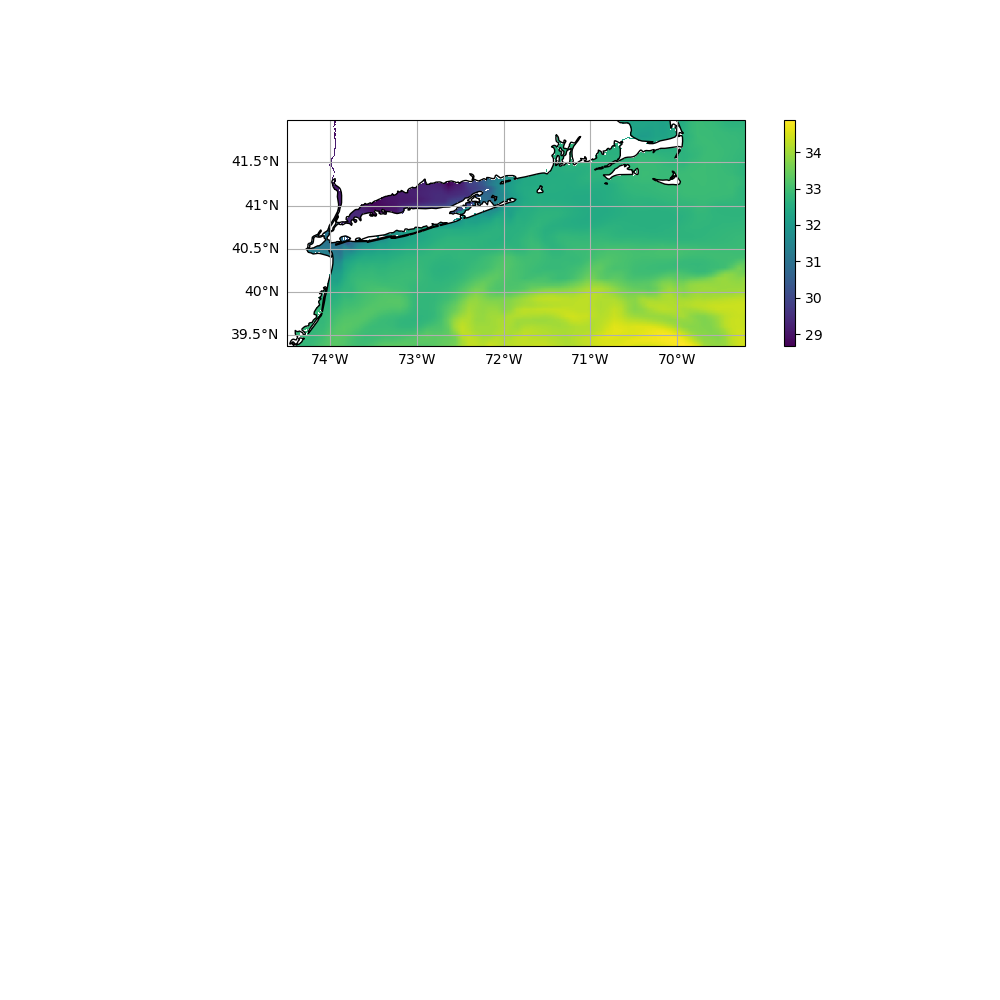

In [18]:
proj = cartopy.crs.Mercator(central_longitude=-98)
pc = cartopy.crs.PlateCarree()
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(3,1,1,projection=pc)
gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False


tmp=xromhisL1_z.salt.values[-1,:,:]
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
#pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp,cmap="binary_r"))
pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp)
#pm=ax2.pcolormesh(xromhisL1.lon_rho,xromhisL1.lat_rho,tmp)

#plt.plot(xromhisL1.lon_rho,xromhisL1.lat_rho,'g+')
#plt.plot(dsqckl0.lon_rho,dsqckl0.lat_rho,'mo')
ax2.coastlines()
plt.colorbar(pm)
plt.plot(tlon,tlat,'r+')

36.08831222786638
56.60844906712988


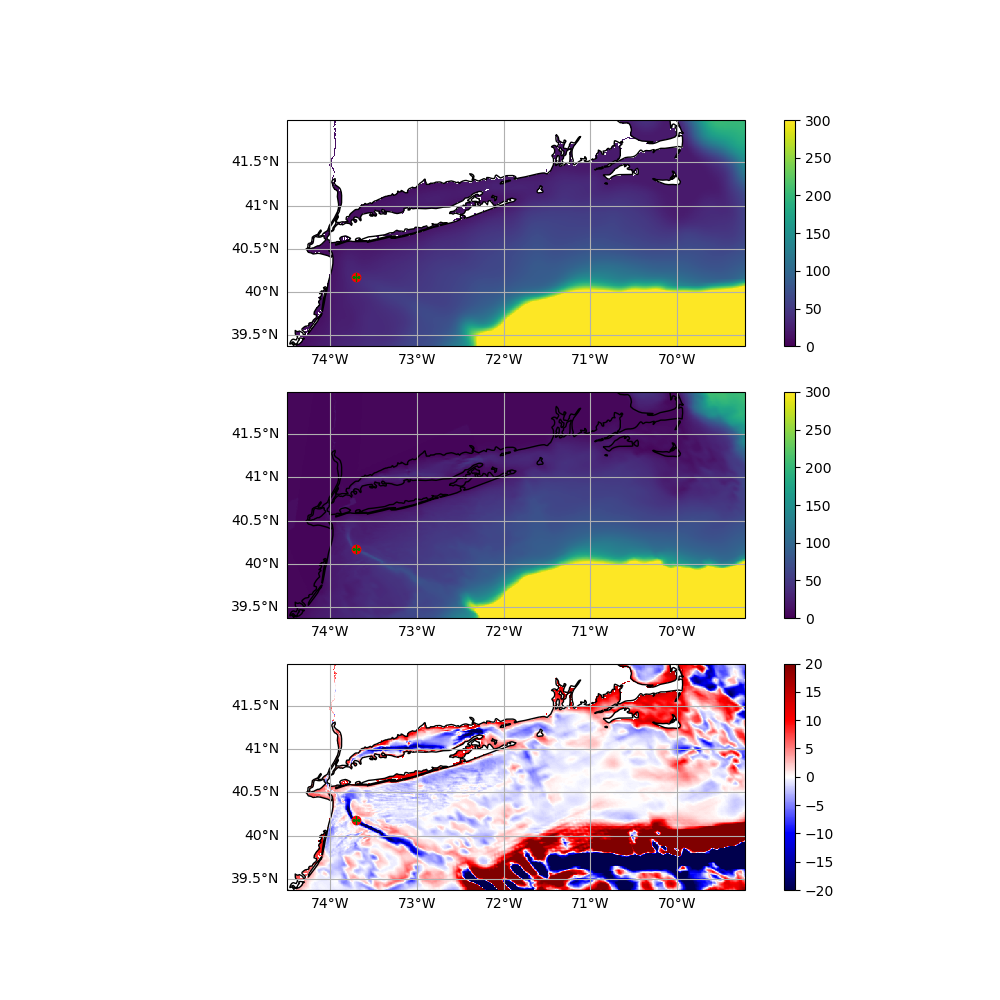

In [19]:
#tmpLL0=xromhisL1.h.isel(eta_rho=30,xi_rho=300)
#tmpLL1=xromhisL1_z.h.isel(eta_rho=30,xi_rho=300)
tmpLL0=xromhisL1.h.isel(eta_rho=100,xi_rho=100)
tmpLL1=xromhisL1_z.h.isel(eta_rho=100,xi_rho=100)
print(tmpLL0.values)
print(tmpLL1.values)
proj = cartopy.crs.Mercator(central_longitude=-98)
pc = cartopy.crs.PlateCarree()
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(3,1,1,projection=pc)
gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
#coast_10m = cfeature.NaturalEarthFeature(
#    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
#)
#ax2.add_feature(coast_10m)

# shape_feature2 = ShapelyFeature([BBOX],
#                                 pc, edgecolor='red', facecolor='none')

#tmp=xromhisL1.z_w.isel(s_w=-1)
tmp=xromhisL1.h
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax2.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=0,vmax=300)
ax2.coastlines()
plt.colorbar(pm)
plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')

ax3 = fig2.add_subplot(3,1,2,projection=pc)
gl = ax3.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
#coast_10m = cfeature.NaturalEarthFeature(
#    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
#)
#ax2.add_feature(coast_10m)

# shape_feature2 = ShapelyFeature([BBOX],
#                                 pc, edgecolor='red', facecolor='none')

#tmp=xromhisL1.zeta
tmp=xromhisL1_z.h
#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax3.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=0,vmax=300)
ax3.coastlines()
plt.colorbar(pm)
plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')



ax4 = fig2.add_subplot(3,1,3,projection=pc)
gl = ax4.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

#tmp=xromhisL1.zeta
tmp=xromhisL1.h-xromhisL1_z.h

#tmp=da2.isel(ocean_time=0,s_rho=0)
#ax2.add_feature(shape_feature2)
pm=ax4.pcolormesh(tmp.lon_rho,tmp.lat_rho,tmp,vmin=-20,vmax=20,cmap='seismic')
ax4.coastlines()

plt.plot(tmpLL0.lon_rho,tmpLL0.lat_rho,'ro')
plt.plot(tmpLL1.lon_rho,tmpLL1.lat_rho,'g+')
plt.colorbar(pm)



